# EEET2574 - ASM3: Big Data Project - Recommender Systems (Traditional Approach)

## Setup

In [85]:
# Importing necessary libraries
import boto3
import sagemaker
from sagemaker import get_execution_role
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
!pip install mplcyberpunk
import mplcyberpunk
warnings.filterwarnings('ignore')  # Suppress all warnings

In [3]:
# Set up SageMaker session and role
role = get_execution_role()
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

[01/08/25 04:50:09] INFO     Found credentials from IAM Role:                                   ]8;id=787255;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=900451;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=566435;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=250117;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[01/08/25 04:50:10] INFO     Created S3 bucket: sagemaker-us-east-1-785920759861                     ]8;id=893929;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=35155;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#723\723]8;;\

## Data Preparation

In [7]:
# Set up S3 bucket paths
data_s3_path = f"s3://bigdata-asm3-team-hanoi/ml-1m"

# Load local data files and upload them to S3
movies_path = f"{data_s3_path}/movies.dat"
ratings_path = f"{data_s3_path}/ratings.dat"
users_path = f"{data_s3_path}/users.dat"

# Load the datasets locally
movies = pd.read_csv(movies_path, delimiter='::', engine='python', header=None, names=['MovieID', 'Title', 'Genres'], encoding='latin1')
ratings = pd.read_csv(ratings_path, delimiter='::', engine='python', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], encoding='latin1')
users = pd.read_csv(users_path, delimiter='::', engine='python', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], encoding='latin1')

print("Datasets loaded from S3.")

Datasets loaded from S3.


In [8]:
# Display the first few rows of each dataframe
print(movies.head())
print(ratings.head())
print(users.head())

   MovieID                               Title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy
   UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291
   UserID Gender  Age  Occupation Zip-code
0       1      F    1          10    48067
1       2      M   56          16    70072
2       3      M   25          15    55117
3       4      M   45           7    02460
4       5      M   25          20    55455


In [9]:
# Check for missing values in data
def check_missing_values(df, name):
    print(f"Missing values in {name}:")
    print(df.isnull().sum())

check_missing_values(movies, "movies")
check_missing_values(ratings, "ratings")
check_missing_values(users, "users")

Missing values in movies:
MovieID    0
Title      0
Genres     0
dtype: int64
Missing values in ratings:
UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64
Missing values in users:
UserID        0
Gender        0
Age           0
Occupation    0
Zip-code      0
dtype: int64


In [10]:
# Check for duplicate rows
def check_duplicates(df, name):
    print(f"Duplicate rows in {name}: {df.duplicated().sum()}")

check_duplicates(movies, "movies")
check_duplicates(ratings, "ratings")
check_duplicates(users, "users")

Duplicate rows in movies: 0
Duplicate rows in ratings: 0
Duplicate rows in users: 0


In [81]:
# Check for common errors in the data
# For movies dataframe: Check for invalid MovieID (should be unique and positive)
print("\nInvalid MovieID in movies dataframe:")
print(movies[movies['MovieID'] <= 0])

# For ratings dataframe: Check for invalid UserID and MovieID (should be positive), and invalid Rating (should be between 1 and 5)
print("\nInvalid UserID in ratings dataframe:")
print(ratings[ratings['UserID'] <= 0])

print("\nInvalid MovieID in ratings dataframe:")
print(ratings[ratings['MovieID'] <= 0])

print("\nInvalid Rating in ratings dataframe:")
print(ratings[(ratings['Rating'] < 1) | (ratings['Rating'] > 5)])

# For users dataframe: Check for invalid UserID (should be unique and positive), invalid Age (should be within a reasonable range), and invalid Gender (should be 'M' or 'F')
print("\nInvalid UserID in users dataframe:")
print(users[users['UserID'] <= 0])

print("\nInvalid Age in users dataframe:")
print(users[(users['Age'] < 1) | (users['Age'] > 100)])  # Assuming age should be between 1 and 100

print("\nInvalid Gender in users dataframe:")
print(users[~users['Gender'].isin(['M', 'F'])])


Invalid MovieID in movies dataframe:
Empty DataFrame
Columns: [MovieID, Title, Genres]
Index: []

Invalid UserID in ratings dataframe:
Empty DataFrame
Columns: [UserID, MovieID, Rating, Timestamp]
Index: []

Invalid MovieID in ratings dataframe:
Empty DataFrame
Columns: [UserID, MovieID, Rating, Timestamp]
Index: []

Invalid Rating in ratings dataframe:
Empty DataFrame
Columns: [UserID, MovieID, Rating, Timestamp]
Index: []

Invalid UserID in users dataframe:
Empty DataFrame
Columns: [UserID, Gender, Age, Occupation, Zip-code]
Index: []

Invalid Age in users dataframe:
Empty DataFrame
Columns: [UserID, Gender, Age, Occupation, Zip-code]
Index: []

Invalid Gender in users dataframe:
Empty DataFrame
Columns: [UserID, Gender, Age, Occupation, Zip-code]
Index: []


## 1. KNN-based Collaborative Filtering (CF)

In this task, we need to implement and evaluate user-based (i.e., user-user) collaborative filtering
that uses kNN (k-nearest neighbour), i.e., kNN-based Collaborative Filtering by randomly choosing
one user (as test set/data) and predict this user's ratings on all movies

In [11]:
# Importing necessary libraries for KNN-based recommendation system
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

In [12]:
# Create a pivot table
user_item_matrix = ratings.pivot(index='UserID', columns='MovieID', values='Rating')
user_item_matrix

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Find the user with the highest number of rated movies (Instead of random I chose this user)
test_user_id = user_item_matrix.count(axis=1).idxmax()
print(f"Test User ID: {test_user_id}")

Test User ID: 4169


In [14]:
test_user_ratings = user_item_matrix.loc[test_user_id]

In [15]:
# Get indices (MovieIDs) of movies rated by the user
rated_movies = test_user_ratings.dropna().index

# Extract the user's ratings as a DataFrame
test_user_data = ratings[ratings['UserID'] == test_user_id]

# Split into training and test sets
train_data, test_data = train_test_split(test_user_data, test_size=0.2, random_state=42)

# Movies in the training and test sets
train_movies = train_data['MovieID'].values
test_movies = test_data['MovieID'].values

print(f"Number of movies rated by the user: {len(rated_movies)}")
print(f"Training set size: {len(train_movies)}")
print(f"Test set size: {len(test_movies)}")

Number of movies rated by the user: 2314
Training set size: 1851
Test set size: 463


In [18]:
user_item_matrix_filled = user_item_matrix.fillna(0)

# Copy the user-item matrix
user_item_matrix_mod = user_item_matrix.copy()

# Remove the test user's ratings for test movies
user_item_matrix_mod.loc[test_user_id, test_movies] = np.nan

In [19]:
user_item_matrix_filled = user_item_matrix.fillna(0)

# Copy the user-item matrix
user_item_matrix_mod = user_item_matrix.copy()

# Remove the test user's ratings for test movies
user_item_matrix_mod.loc[test_user_id, test_movies] = np.nan

In [20]:
# Compute cosine similarity
user_similarity_cosine = cosine_similarity(user_item_matrix_filled)
user_similarity_cosine = pd.DataFrame(user_similarity_cosine, index=user_item_matrix.index, columns=user_item_matrix.index)

In [21]:
# Compute Pearson correlation
user_similarity_pearson = user_item_matrix.T.corr()

In [22]:
def compute_jaccard_similarity(user_item_matrix):
    # Convert ratings to binary values: 1 if rated, 0 if not
    user_item_binary = user_item_matrix.notna().astype(int)
    # Compute Jaccard distance and convert to similarity
    jaccard_distances = pairwise_distances(user_item_binary.to_numpy(), metric='jaccard')
    user_similarity_jaccard = 1 - jaccard_distances
    user_similarity_jaccard = pd.DataFrame(user_similarity_jaccard, index=user_item_binary.index, columns=user_item_binary.index)
    return user_similarity_jaccard

# Compute Jaccard similarity
user_similarity_jaccard = compute_jaccard_similarity(user_item_matrix_mod)

In [23]:
def get_top_k_neighbors(similarity_matrix, user_id, k):
    # Exclude the user itself
    sim_scores = similarity_matrix[user_id].drop(user_id)
    # Sort users by similarity score
    top_k_users = sim_scores.nlargest(k).index
    return top_k_users

def predict_rating(user_id, item_id, user_item_matrix, similarity_matrix, k):
    top_k_users = get_top_k_neighbors(similarity_matrix, user_id, k)
    # Get ratings of the top k users for the item
    top_k_ratings = user_item_matrix.loc[top_k_users, item_id]
    # Get similarities
    top_k_similarities = similarity_matrix.loc[user_id, top_k_users]
    # Filter out users who haven't rated the item
    mask = top_k_ratings.notna()
    if mask.sum() == 0:
        # No neighbors have rated the item
        return user_item_matrix.loc[user_id].mean()
    else:
        # Compute weighted average
        numerator = (top_k_ratings[mask] * top_k_similarities[mask]).sum()
        denominator = top_k_similarities[mask].sum()
        if denominator == 0:
            return user_item_matrix.loc[user_id].mean()
        else:
            return numerator / denominator

In [24]:
def predict_ratings_for_test_set(user_id, test_movies, user_item_matrix, similarity_matrix, k):
    predictions = []
    for item_id in test_movies:
        pred_rating = predict_rating(user_id, item_id, user_item_matrix, similarity_matrix, k)
        predictions.append(pred_rating)
    return np.array(predictions)

In [25]:
# Later needed for evaluation
actual_ratings = test_data['Rating'].values

In [26]:
k_values = [5, 10, 20, 50, 100, 200, 500]
rmse_results_cosine = {}
rmse_results_pearson = {}
rmse_results_jaccard_score = {}

for k in k_values:
    
    # Cosine similarity predictions
    predicted_ratings_cosine = predict_ratings_for_test_set(
        test_user_id, test_movies, user_item_matrix_mod, user_similarity_cosine, k)
    rmse_cosine = root_mean_squared_error(actual_ratings, predicted_ratings_cosine)
    rmse_results_cosine[k] = rmse_cosine
    print(f"Cosine Similarity - RMSE for k={k}: {rmse_cosine}")
    
    # Pearson correlation predictions
    predicted_ratings_pearson = predict_ratings_for_test_set(
        test_user_id, test_movies, user_item_matrix_mod, user_similarity_pearson, k)
    rmse_pearson = root_mean_squared_error(actual_ratings, predicted_ratings_pearson)
    rmse_results_pearson[k] = rmse_pearson
    print(f"Pearson Correlation - RMSE for k={k}: {rmse_pearson}")
    
    # Jaccard similarity predictions using jaccard_score
    predicted_ratings_jaccard_score = predict_ratings_for_test_set(
        test_user_id, test_movies, user_item_matrix_mod, user_similarity_jaccard, k)
    rmse_jaccard_score = root_mean_squared_error(actual_ratings, predicted_ratings_jaccard_score)
    rmse_results_jaccard_score[k] = rmse_jaccard_score
    print(f"Jaccard Similarity - RMSE for k={k}: {rmse_jaccard_score}\n")

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'k': k_values,
    'Cosine RMSE': [rmse_results_cosine[k] for k in k_values],
    'Pearson RMSE': [rmse_results_pearson[k] for k in k_values],
    'Jaccard RMSE': [rmse_results_jaccard_score[k] for k in k_values]
})

Cosine Similarity - RMSE for k=5: 1.029945710749855
Pearson Correlation - RMSE for k=5: 1.0277187164180779
Jaccard Similarity - RMSE for k=5: 1.020599205763851

Cosine Similarity - RMSE for k=10: 0.9489164789272778
Pearson Correlation - RMSE for k=10: 1.0221762583330225
Jaccard Similarity - RMSE for k=10: 0.975636693381566

Cosine Similarity - RMSE for k=20: 0.9056528190719828
Pearson Correlation - RMSE for k=20: 1.0102115169048413
Jaccard Similarity - RMSE for k=20: 0.9296301558186477

Cosine Similarity - RMSE for k=50: 0.8809829557393424
Pearson Correlation - RMSE for k=50: 0.9559202448683919
Jaccard Similarity - RMSE for k=50: 0.8963960575955268

Cosine Similarity - RMSE for k=100: 0.8504903736936885
Pearson Correlation - RMSE for k=100: 0.9388289351512823
Jaccard Similarity - RMSE for k=100: 0.8667575115143586

Cosine Similarity - RMSE for k=200: 0.8359176975673485
Pearson Correlation - RMSE for k=200: 0.865908831773361
Jaccard Similarity - RMSE for k=200: 0.8533029294660859

Cosin

In [27]:
# Print the formatted output
print("RMSE Results for Different Similarity Measures:")
print(results_df.to_string(index=False))

RMSE Results for Different Similarity Measures:
  k  Cosine RMSE  Pearson RMSE  Jaccard RMSE
  5     1.029946      1.027719      1.020599
 10     0.948916      1.022176      0.975637
 20     0.905653      1.010212      0.929630
 50     0.880983      0.955920      0.896396
100     0.850490      0.938829      0.866758
200     0.835918      0.865909      0.853303
500     0.832831      0.773722      0.850203


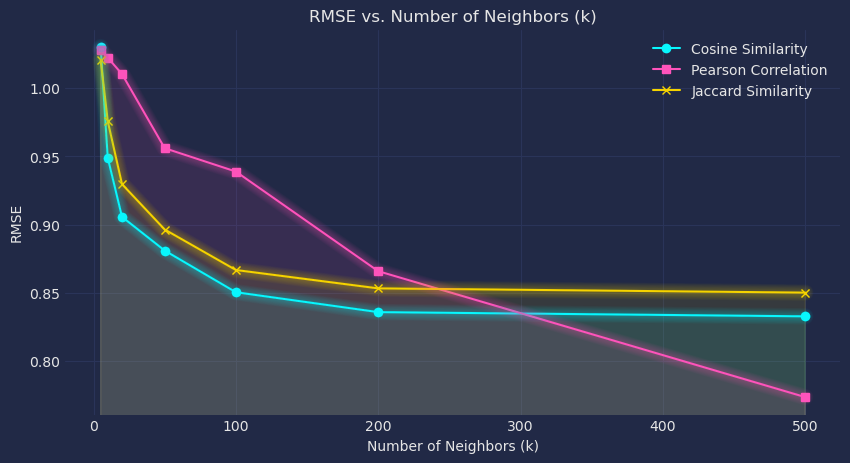

In [28]:
import matplotlib.pyplot as plt
import mplcyberpunk

plt.style.use("cyberpunk")
plt.figure(figsize=(10, 5))
plt.plot(k_values, [rmse_results_cosine[k] for k in k_values], marker='o', label='Cosine Similarity')
plt.plot(k_values, [rmse_results_pearson[k] for k in k_values], marker='s', label='Pearson Correlation')
plt.plot(k_values, [rmse_results_jaccard_score[k] for k in k_values], marker='x', label='Jaccard Similarity')
plt.title('RMSE vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('RMSE')
plt.legend()
mplcyberpunk.add_glow_effects()
plt.show()

## 2. Matrix Factorization Based-Recommendation

In this task, we need to explore, implement, and evaluate a recommender system that uses a
matrix factorization technique (SVD - Singular Value Decomposition) by randomly choosing 5 items (i.e., movies; as test set) and predict all users' ratings on these movies.

In [31]:
# Importing necessary libraries for SVD-based recommendation system
!pip install surprise
from surprise import Dataset, Reader, SVD, accuracy
import random

In [32]:
# Get a list of unique MovieIDs
movie_ids = ratings['MovieID'].unique()

# Randomly select 5 movies
test_movie_ids = np.random.choice(movie_ids, size=5, replace=False)
print(f"Test Movie IDs: {test_movie_ids}")

Test Movie IDs: [ 510 2102 3526 2237 2952]


In [33]:
# Test Movie IDs
test_movie_ids = [2853, 43, 2275, 1851, 2402]

# Filter the DataFrame to get information for the test movie IDs
test_movies_info = movies[movies['MovieID'].isin(test_movie_ids)]

# Print the movie information in a formatted manner
print("Movie Information for Test Movie IDs:\n")
print(test_movies_info.to_string(index=False))

Movie Information for Test Movie IDs:

 MovieID                                                    Title                  Genres
      43                                       Restoration (1995)                   Drama
    1851                         Leather Jacket Love Story (1997)           Drama|Romance
    2275                                Six-String Samurai (1998) Action|Adventure|Sci-Fi
    2402                        Rambo: First Blood Part II (1985)              Action|War
    2853 Communion (a.k.a. Alice, Sweet Alice/Holy Terror) (1977)                  Horror


In [34]:
reader = Reader(line_format='user item rating timestamp', sep='::', skip_lines=0)

In [43]:
dataset_ratings = ratings[['UserID', 'MovieID', 'Rating']] 
data = Dataset.load_from_df(dataset_ratings, reader=reader)

In [46]:
df = pd.DataFrame(data.raw_ratings, columns=['UserID', 'MovieID', 'Rating', 'Timestamp'])
df['UserID'] = df['UserID'].astype(int)
df['MovieID'] = df['MovieID'].astype(int)

In [47]:
# Ensure test_movie_ids is a list and types match
test_movie_ids = list(map(int, test_movie_ids))

# Training data excludes the test movies
train_df = df[~df['MovieID'].isin(test_movie_ids)]

# Test data includes only the test movies
test_df = df[df['MovieID'].isin(test_movie_ids)]

In [48]:
# Create a Reader object
reader = Reader(rating_scale=(1, 5))

# Load training data
train_data = Dataset.load_from_df(train_df[['UserID', 'MovieID', 'Rating']], reader)

# Build the full training set
trainset = train_data.build_full_trainset()

In [49]:
algo = SVD()
algo.fit(trainset)

In [50]:
# Build a list of (user, item) pairs for which we want predictions
testset = list(zip(test_df['UserID'], test_df['MovieID'], test_df['Rating']))

In [51]:
predictions = algo.test(testset)

In [52]:
# Compute RMSE
rmse = accuracy.rmse(predictions)
print(f"RMSE of the original SVD model: {rmse}")

RMSE: 1.0976
RMSE of the original SVD model: 1.097558180362015


In [53]:
from surprise.model_selection import GridSearchCV

In [54]:
param_grid = {
    'n_factors': [5, 10, 20],
    'n_epochs': [5, 10, 20], 
    'lr_all': [0.001, 0.005, 0.02],
    'reg_all': [0.005, 0.02, 0.1]
}

In [55]:
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1, return_train_measures=True)

# Use the training data for grid search
gs.fit(train_data)

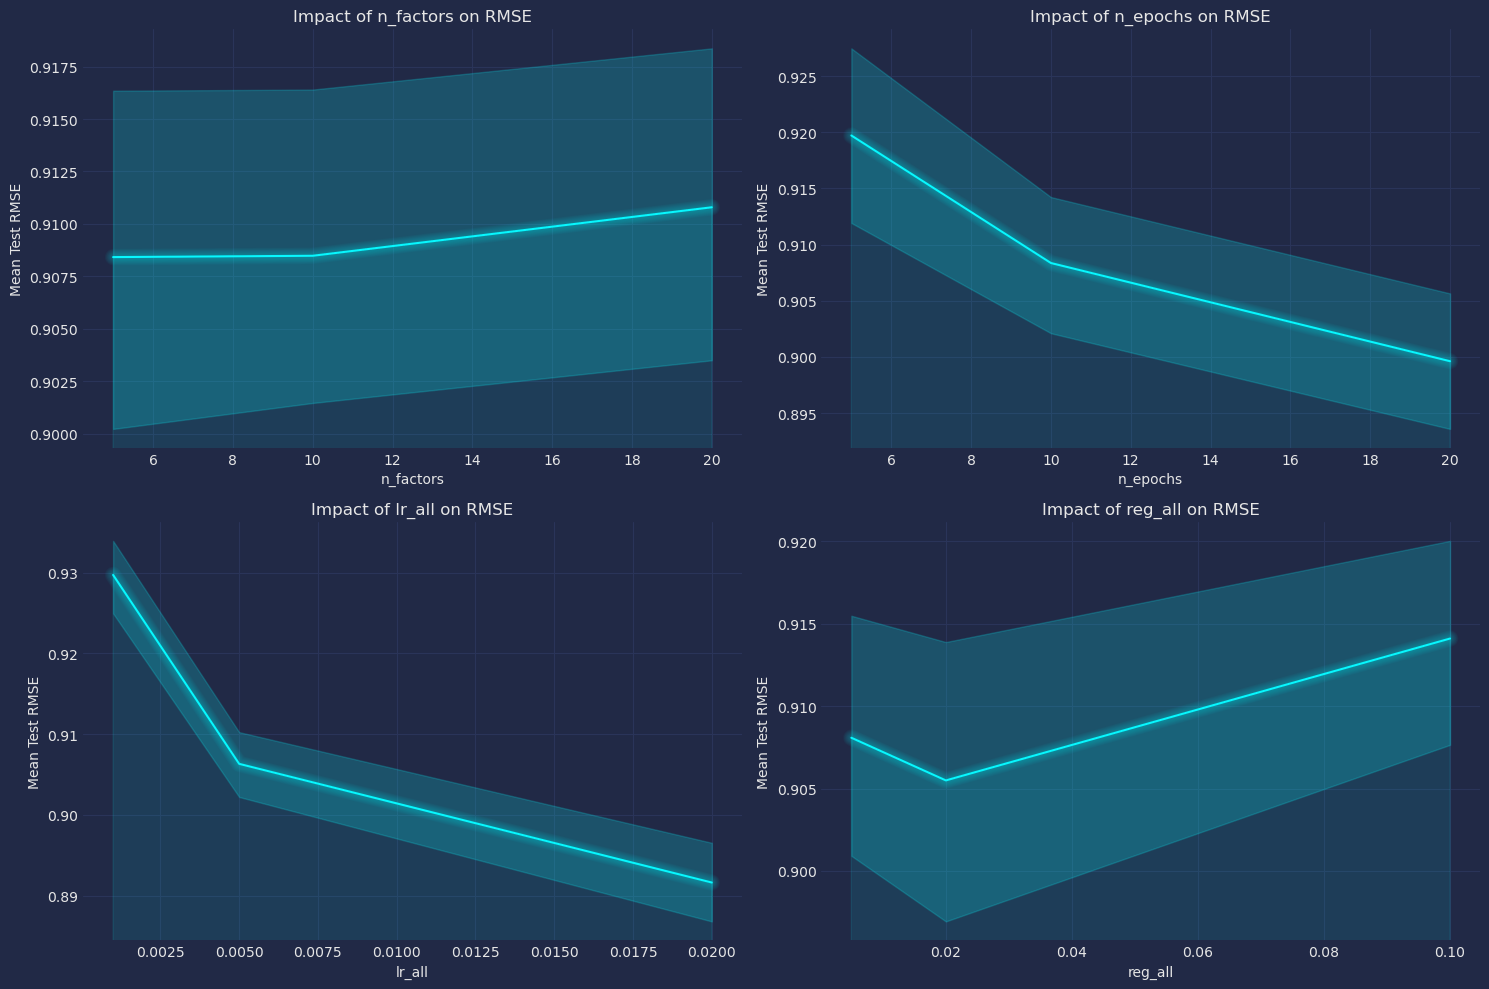

In [56]:
# Visualize the impact of parameters in param_grid on performance
results_df = pd.DataFrame.from_dict(gs.cv_results)
param_names = list(param_grid.keys())

plt.figure(figsize=(15, 10))
for i, param in enumerate(param_names, 1):
    plt.subplot(2, 2, i)
    sns.lineplot(data=results_df, x=f'param_{param}', y='mean_test_rmse')
    mplcyberpunk.add_glow_effects()
    plt.title(f'Impact of {param} on RMSE')
    plt.xlabel(param)
    plt.ylabel('Mean Test RMSE')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [57]:
print("Best RMSE score attained:", gs.best_score['rmse'])
print("Optimal hyperparameters:", gs.best_params['rmse'])

Best RMSE score attained: 0.8750064532297572
Optimal hyperparameters: {'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.02, 'reg_all': 0.02}


In [84]:
algo_optimized = gs.best_estimator['rmse']
# Train on the full training set
algo_optimized.fit(trainset)

predictions_optimized = algo_optimized.test(testset)
# Compute RMSE
rmse_optimized = accuracy.rmse(predictions_optimized)
print(f"RMSE of the optimized SVD model: {rmse_optimized}")

RMSE: 0.7971
RMSE of the optimized SVD model: 0.7970804001081083


## 3. Ranking-based Evaluation and Comparison

In this task, we will conduct ranking-based evaluation and comparison of the two models implemented previously by randomly choosing 10 users (from who have rated
more than 100 movies each; as test set) and recommend Top-20 movies to each of them. We will use AP (Average Precision) and NDCG (Normalized Discounted Cumulative Gain) as evaluation metrics.

In [59]:
# Get users with more than 100 ratings
user_rating_counts = ratings['UserID'].value_counts()
eligible_users = user_rating_counts[user_rating_counts > 100].index.tolist()

print(f"Number of users with more than 100 ratings: {len(eligible_users)}")


Number of users with more than 100 ratings: 2909


In [60]:
# Randomly select 10 users
test_users = np.random.choice(eligible_users, size=10, replace=False)
print(f"Selected Test Users: {test_users}")

Selected Test Users: [1182 3053 1490 2776  850 4252  504  148 1860 3426]


In [61]:
# Create dictionaries to hold train and test ratings for test users
test_user_train_ratings = {}
test_user_test_ratings = {}

for user in test_users:
    user_ratings = ratings[ratings['UserID'] == user]
    user_ratings = user_ratings.sample(frac=1, random_state=1)  # Shuffle user ratings
    num_ratings = len(user_ratings)
    split_point = int(0.8 * num_ratings)
    
    # Split into training and test sets
    train_ratings = user_ratings.iloc[:split_point]
    test_ratings = user_ratings.iloc[split_point:]
    
    test_user_train_ratings[user] = train_ratings
    test_user_test_ratings[user] = test_ratings


In [62]:
# Exclude test users' test set ratings from the overall dataset
# Create a mask for ratings to exclude
exclude_indices = []

for user in test_users:
    exclude_indices.extend(test_user_test_ratings[user].index.tolist())

# Create the modified dataset for training
modified_ratings = ratings.drop(exclude_indices)


In [63]:
# Prepare data for Surprise library
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(modified_ratings[['UserID', 'MovieID', 'Rating']], reader)
trainset = data.build_full_trainset()

# Prepare user-item matrix for KNNCF
user_item_matrix = modified_ratings.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)

In [64]:
# Compute user similarity matrix for KNNCF
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

In [65]:
def knn_predict_rating(user_id, item_id, user_item_matrix, user_similarity_df, k):
    # Get the k most similar users
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:k+1].index
    # Get ratings for the item from similar users
    similar_users_ratings = user_item_matrix.loc[similar_users, item_id]
    # Compute the weighted average rating
    sim_scores = user_similarity_df.loc[user_id, similar_users]
    weighted_ratings = similar_users_ratings * sim_scores
    sum_sim = sim_scores[similar_users_ratings.notna()].sum()
    if sum_sim > 0:
        predicted_rating = weighted_ratings.sum() / sum_sim
    else:
        predicted_rating = user_item_matrix.loc[user_id].mean()
    return predicted_rating


In [66]:
# Initialize the SVD model with optimized hyperparameters
svd_model = gs.best_estimator['rmse']

# Train the model
svd_model.fit(trainset)

In [67]:
def svd_predict_rating(user_id, item_id, svd_model):
    prediction = svd_model.predict(user_id, item_id, verbose=False)
    return prediction.est


In [68]:
def get_binary_relevance(test_ratings, threshold=4):
    # Assign 1 if rating >= threshold, else 0
    binary_relevance = test_ratings['Rating'].apply(lambda x: 1 if x >= threshold else 0)
    return binary_relevance.values


In [70]:
from sklearn.metrics import ndcg_score, average_precision_score
import numpy as np
from tqdm import tqdm

results = []

for user in tqdm(test_users, desc="Evaluating Recommendations"):
    test_ratings = test_user_test_ratings[user]
    if test_ratings.empty:
        continue
    
    # Get the list of items in the user's test set
    test_items = test_ratings['MovieID'].tolist()
    
    # Get the ground truth binary relevance labels
    y_true = get_binary_relevance(test_ratings)
    
    # KNNCF Predicted Scores
    knn_pred_scores = []
    for item_id in test_items:
        pred_score = knn_predict_rating(user, item_id, user_item_matrix, user_similarity_df, k)
        knn_pred_scores.append(pred_score)
    
    # SVD Predicted Scores
    svd_pred_scores = []
    for item_id in test_items:
        pred_score = svd_model.predict(user, item_id, verbose=False).est
        svd_pred_scores.append(pred_score)
    
    # Limit to top 20 items
    # KNNCF Top 20
    knn_top_indices = np.argsort(knn_pred_scores)[::-1][:20]
    knn_top_scores = [knn_pred_scores[i] for i in knn_top_indices]
    knn_y_true_top = [y_true[i] for i in knn_top_indices]
    
    # SVD Top 20
    svd_top_indices = np.argsort(svd_pred_scores)[::-1][:20]
    svd_top_scores = [svd_pred_scores[i] for i in svd_top_indices]
    svd_y_true_top = [y_true[i] for i in svd_top_indices]
    
    # Prepare inputs for scikit-learn functions
    knn_y_true_array = np.array([knn_y_true_top])
    knn_pred_scores_array = np.array([knn_top_scores])
    
    svd_y_true_array = np.array([svd_y_true_top])
    svd_pred_scores_array = np.array([svd_top_scores])
    
    # Compute NDCG
    knn_ndcg = ndcg_score(knn_y_true_array, knn_pred_scores_array, k=20)
    svd_ndcg = ndcg_score(svd_y_true_array, svd_pred_scores_array, k=20)
    
    # Compute Average Precision
    knn_ap = average_precision_score(knn_y_true_top, knn_top_scores)
    svd_ap = average_precision_score(svd_y_true_top, svd_top_scores)
    
    # Store the results
    results.append({
        'UserID': user,
        'KNNCF_AP': knn_ap,
        'KNNCF_NDCG': knn_ndcg,
        'IMFR_AP': svd_ap,
        'IMFR_NDCG': svd_ndcg
    })



Evaluating Recommendations: 100%|██████████| 10/10 [00:01<00:00,  7.61it/s]


In [71]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Calculate mean AP and NDCG
mean_ap_knncf = results_df['KNNCF_AP'].mean()
mean_ndcg_knncf = results_df['KNNCF_NDCG'].mean()

mean_ap_imfr = results_df['IMFR_AP'].mean()
mean_ndcg_imfr = results_df['IMFR_NDCG'].mean()

print("\nMean AP and NDCG for KNNCF:")
print(f"Mean AP: {mean_ap_knncf:.4f}")
print(f"Mean NDCG: {mean_ndcg_knncf:.4f}")

print("\nMean AP and NDCG for IMFR:")
print(f"Mean AP: {mean_ap_imfr:.4f}")
print(f"Mean NDCG: {mean_ndcg_imfr:.4f}")



Mean AP and NDCG for KNNCF:
Mean AP: 0.8537
Mean NDCG: 0.9426

Mean AP and NDCG for IMFR:
Mean AP: 0.9274
Mean NDCG: 0.9782


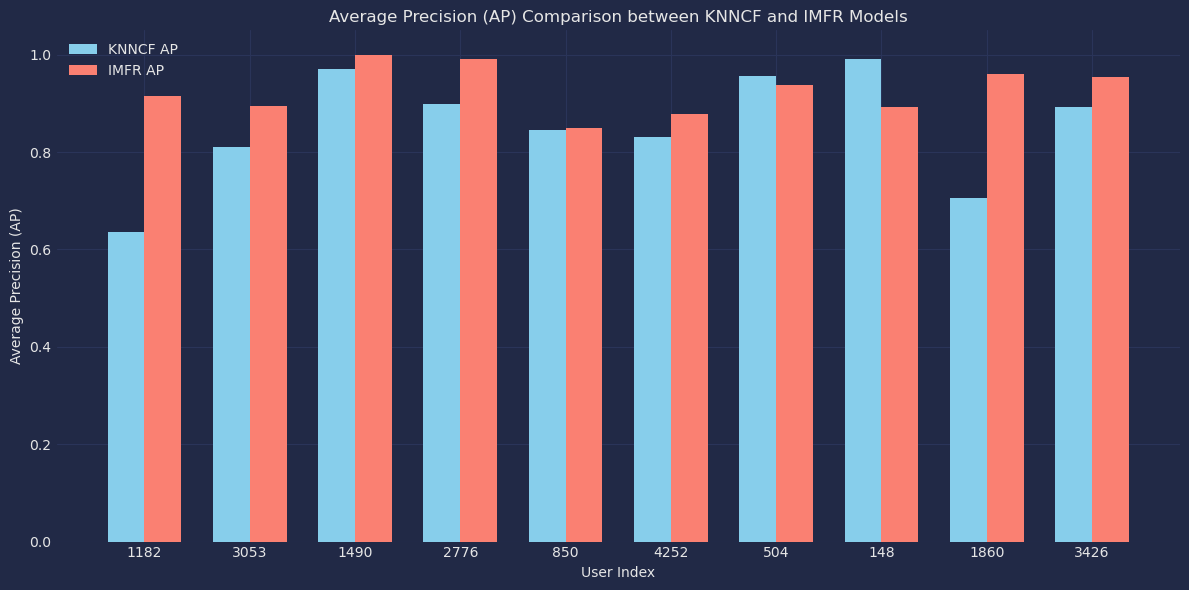

In [72]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Bar plot for AP
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(results_df))
plt.bar(index, results_df['KNNCF_AP'], bar_width, label='KNNCF AP', color='skyblue')
plt.bar(index + bar_width, results_df['IMFR_AP'], bar_width, label='IMFR AP', color='salmon')
plt.xlabel('User Index')
plt.ylabel('Average Precision (AP)')
plt.title('Average Precision (AP) Comparison between KNNCF and IMFR Models')
plt.xticks(index + bar_width / 2, results_df['UserID'])
plt.legend()
plt.tight_layout()
plt.show()

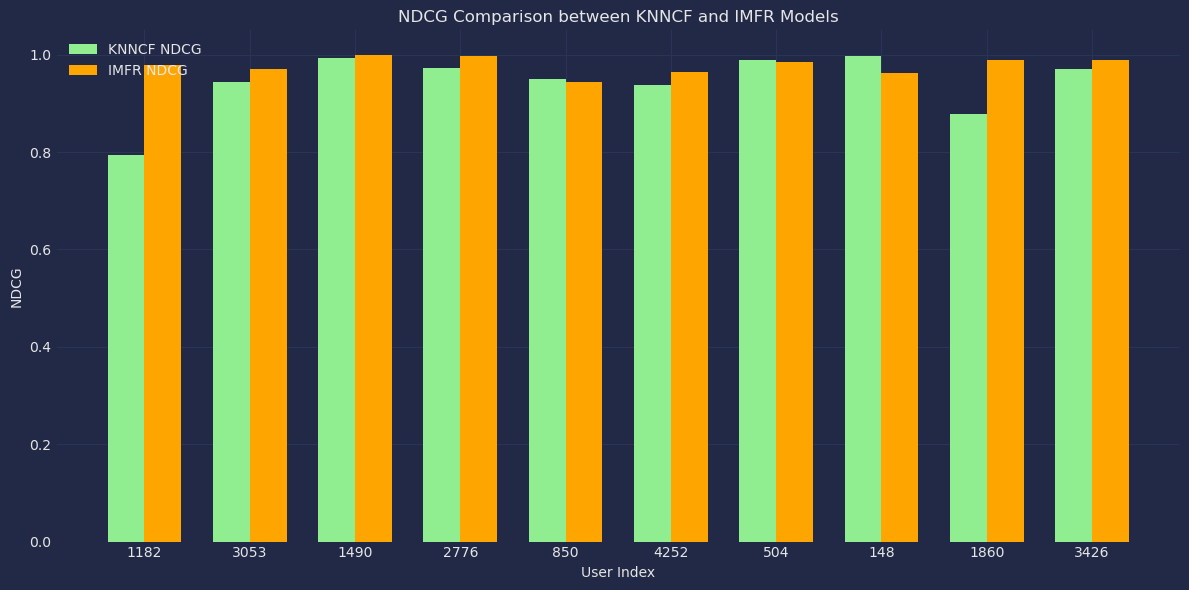

In [73]:
# Bar plot for NDCG
plt.figure(figsize=(12, 6))
plt.bar(index, results_df['KNNCF_NDCG'], bar_width, label='KNNCF NDCG', color='lightgreen')
plt.bar(index + bar_width, results_df['IMFR_NDCG'], bar_width, label='IMFR NDCG', color='orange')
plt.xlabel('User Index')
plt.ylabel('NDCG')
plt.title('NDCG Comparison between KNNCF and IMFR Models')
plt.xticks(index + bar_width / 2, results_df['UserID'])
plt.legend()
plt.tight_layout()
plt.show()

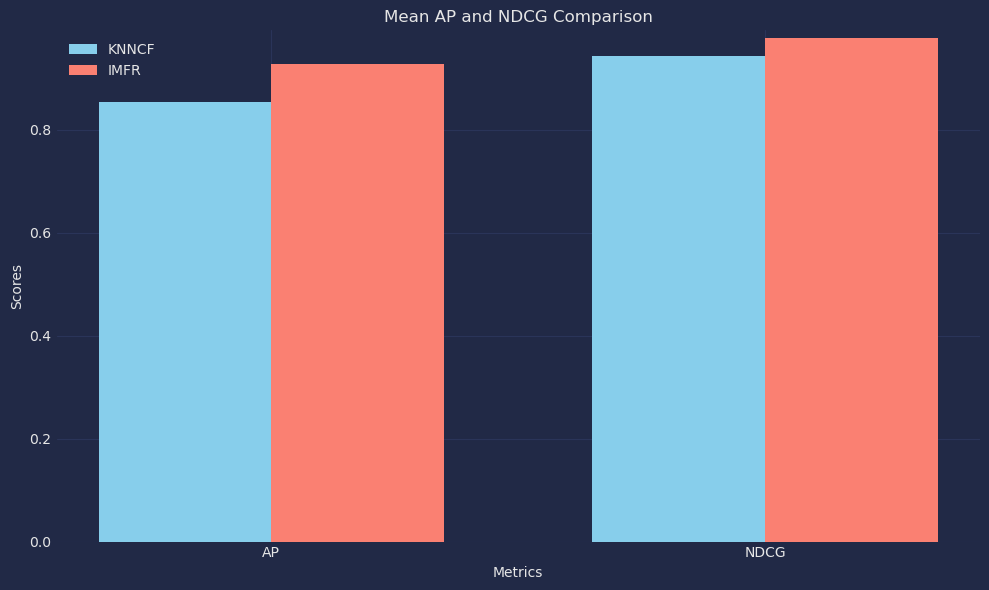

In [74]:
# Plotting Mean AP and NDCG
plt.figure(figsize=(10, 6))
metrics = ['AP', 'NDCG']
knn_values = [mean_ap_knncf, mean_ndcg_knncf]
imfr_values = [mean_ap_imfr, mean_ndcg_imfr]

x = np.arange(len(metrics))  # label locations
width = 0.35  # width of the bars

plt.bar(x - width/2, knn_values, width, label='KNNCF', color='skyblue')
plt.bar(x + width/2, imfr_values, width, label='IMFR', color='salmon')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Mean AP and NDCG Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0, max(knn_values) + 0.05)
plt.tight_layout()
plt.show()

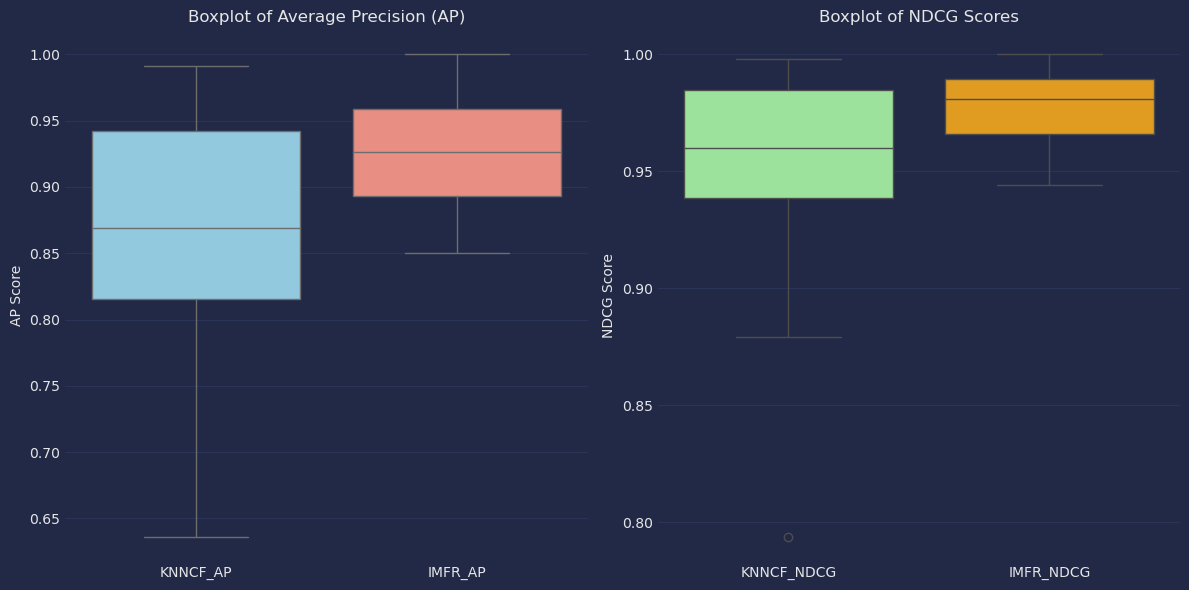

In [75]:
# Detailed boxplots
plt.figure(figsize=(12, 6))

# Boxplot for AP
plt.subplot(1, 2, 1)
sns.boxplot(data=results_df[['KNNCF_AP', 'IMFR_AP']], palette=['skyblue', 'salmon'])
plt.title('Boxplot of Average Precision (AP)')
plt.ylabel('AP Score')

# Boxplot for NDCG
plt.subplot(1, 2, 2)
sns.boxplot(data=results_df[['KNNCF_NDCG', 'IMFR_NDCG']], palette=['lightgreen', 'orange'])
plt.title('Boxplot of NDCG Scores')
plt.ylabel('NDCG Score')

plt.tight_layout()
plt.show()

In [76]:
from tqdm import tqdm

# Lists to store results
knn_predictions = []
svd_predictions = []
actual_ratings = []


In [77]:
for user in tqdm(test_users, desc="Evaluating Users"):
    test_ratings = test_user_test_ratings[user]
    user_train_rated_items = test_user_train_ratings[user]['MovieID'].tolist()
    
    # Get items in the test set
    test_items = test_ratings['MovieID'].tolist()
    test_actual_ratings = test_ratings['Rating'].tolist()
    
    for item_id, actual_rating in zip(test_items, test_actual_ratings):
        # Skip items already rated in training (shouldn't happen, but just in case)
        if item_id in user_train_rated_items:
            continue
        
        # KNNCF Prediction
        try:
            knn_pred = knn_predict_rating(user, item_id, user_item_matrix, user_similarity_df, k)
        except KeyError:
            # If item_id not in user_item_matrix columns
            knn_pred = user_item_matrix.loc[user].mean()
        
        # SVD Prediction
        svd_pred = svd_predict_rating(user, item_id, svd_model)
        
        # Store the predictions and actual ratings
        knn_predictions.append(knn_pred)
        svd_predictions.append(svd_pred)
        actual_ratings.append(actual_rating)
        


Evaluating Users: 100%|██████████| 10/10 [00:01<00:00,  7.87it/s]


In [78]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [80]:
# KNNCF Metrics
knn_rmse = np.sqrt(mean_squared_error(actual_ratings, knn_predictions))
knn_mae = mean_absolute_error(actual_ratings, knn_predictions)

# SVD Metrics
svd_rmse = np.sqrt(mean_squared_error(actual_ratings, svd_predictions))
svd_mae = mean_absolute_error(actual_ratings, svd_predictions)

print("\nKNNCF Performance:")
print(f"RMSE: {knn_rmse:.4f}")
print(f"MAE: {knn_mae:.4f}")

print("\nSVD Performance:")
print(f"RMSE: {svd_rmse:.4f}")
print(f"MAE: {svd_mae:.4f}")


KNNCF Performance:
RMSE: 2.4907
MAE: 2.2136

SVD Performance:
RMSE: 0.8020
MAE: 0.6250


## References 

[1] A. Sharma, J. N. K. S, D. Rana and S. Setia, "A Review On Collaborative Filtering Using Knn Algorithm," 2022 OPJU International Technology Conference on Emerging

Technologies for Sustainable Development (OTCON), Raigarh, Chhattisgarh, India, 2023, pp. 1-6, doi: 10.1109/OTCON56053.2023.10113985.

[2] T. Chai and R. R. Draxler, “Root mean square error (RMSE) or mean absolute error (MAE)? – Arguments against avoiding RMSE in the literature,” Geoscientific
Model Development, vol. 7, no. 3, pp. 1247–1250, Jun. 2014, doi: https://doi.org/10.5194/gmd-7-1247-2014.

[3] Qilong Ba, Xiaoyong Li and Zhongying Bai, "Clustering collaborative filtering recommendation system based on SVD algorithm," 2013 IEEE 4th International
Conference on Software Engineering and Service Science, Beijing, 2013, pp. 963-967, doi: 10.1109/ICSESS.2013.6615466.

[4] N. Hug, “Home,” Surprise. https://surpriselib.com/

[5] Pirjatullah, D. Kartini, D. T. Nugrahadi, Muliadi and A. Farmadi, "Hyperparameter Tuning using GridsearchCV on The Comparison of The Activation Function of The
ELM Method to The Classification of Pneumonia in Toddlers," 2021 4th International Conference of Computer and Informatics Engineering (IC2IE), Depok, Indonesia,
2021, pp. 390-395, doi: 10.1109/IC2IE53219.2021.9649207.

[6] A. Nakashima and H. Ogawa, "How to design a regularization term for improving generalization," ICONIP'99. ANZIIS'99 & ANNES'99 & ACNN'99. 6th International
Conference on Neural Information Processing. Proceedings (Cat. No.99EX378), Perth, WA, Australia, 1999, pp. 222-227 vol.1, doi: 10.1109/ICONIP.1999.843990.

[7] D. Shah, “Mean Average Precision (mAP) Explained: Everything You Need to Know,” www.v7labs.com, Mar. 07, 2022. https://www.v7labs.com/blog/mean-average-
precision

[8] “Normalized Discounted Cumulative Gain (NDCG) explained,” www.evidentlyai.com. https://www.evidentlyai.com/ranking-metrics/ndcg-metric

[9] R. Medar, V. S. Rajpurohit and B. Rashmi, "Impact of Training and Testing Data Splits on Accuracy of Time Series Forecasting in Machine Learning," 2017 International Conference on Computing, Communication, Control and Automation (ICCUBEA), Pune, India, 2017, pp. 1-6, doi: 10.1109/ICCUBEA.2017.8463779.

[10] S. Zhang, "Challenges in KNN Classification," in IEEE Transactions on Knowledge and Data Engineering, vol. 34, no. 10, pp. 4663-4675, 1 Oct. 2022, doi:
10.1109/TKDE.2021.3049250.

[11] H. Wang, "Alleviating Sparsity Problem of Recommender System with No Extra Input Data," 2022 5th International Conference on Advanced Electronic Materials,
Computers and Software Engineering (AEMCSE), Wuhan, China, 2022, pp. 691-695, doi: 10.1109/AEMCSE55572.2022.00139.

[12] “Cold start (recommender systems) - Wikiwand,” Wikiwand.com, 2021. https://www.wikiwand.com/en/articles/Cold_start_(recommender_systems) (accessed Nov.
03, 2024).

[13] K.-C. memory, “Is a KNN-Classifier memory intensive?,” Computer Science Stack Exchange, Jan. 06, 2015. https://cs.stackexchange.com/questions/36012/is-a-knn-
classifier-memory-intensive (accessed Nov. 03, 2024).

[14] G. T. Reddy et al., "Analysis of Dimensionality Reduction Techniques on Big Data," in IEEE Access, vol. 8, pp. 54776-54788, 2020, doi: 10.1109/ACCESS.2020.2980942.

[15] S. A. Dudani, "The Distance-Weighted k-Nearest-Neighbor Rule," in IEEE Transactions on Systems, Man, and Cybernetics, vol. SMC-6, no. 4, pp. 325-327, April 1976,
doi: 10.1109/TSMC.1976.5408784.
keywords: {Nearest neighbor searches;Error correction;Upper bound;H infinity control},

[16] D. B. Davidson, "Parallel computing," in IEEE Potentials, vol. 14, no. 2, pp. 6-10, April-May 1995, doi: 10.1109/45.376635.